# Find lane marks on a single image

# Projekt 1

#### Import dependencies 

In [1]:
#Import releveant packages
import matplotlib.pyplot as byplot
import matplotlib.image as mpimage
import numpy as numpy
import cv2 as cv
import math as mat
import os
import time as time
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

#### Create Class laneFinder

In [2]:
class laneFinder:
    def find(self,imgOrVidPath):
        filename, file_extension = os.path.splitext(imgOrVidPath)
        if file_extension == ".mp4":
            self.findLanesOnVid(imgOrVidPath)
        else:
            self.findLanesOnImg(mpimage.imread(imgOrVidPath),False)
            
    def findLanesOnImg(self, img ,isVideo = True):
        smooth_img = self.smoothImage(img)
        gray_img = self.imageToGray(smooth_img)
        masked_img = self.maskImage(gray_img)
        thres_img = self.imageBelowThresToBlack(masked_img)
        canny_edges = self.cannyEdgeDetection(thres_img)
        hough_lines = self.houghLines(canny_edges)
        output = self.houghLinesToImage(img,hough_lines,isVideo)
        if isVideo:
            return output
        
    def findLanesOnVid(self,vidPath):
        filename, file_extension = os.path.splitext(vidPath)
        clip1 = VideoFileClip(vidPath)
        white_clip = clip1.fl_image(self.findLanesOnImg)
        %time white_clip.write_videofile('test_videos_output/' + filename.rsplit('/',1)[1] + file_extension, audio=False)

        
    ### Image Prepreperation
    
    ## Smoothen image with gaussian blur, optional kernel_size
    def smoothImage(self, img, kernel_size = 7):
        smooth_img = cv.GaussianBlur(img, (kernel_size, kernel_size), 0)
        return  smooth_img
    
     ## Convert image to grayscale
    def imageToGray(self,img):
        gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        return gray_img
    
    ## Define region of interest and return masked image, optional vertices(defining ROI)
    def maskImage(self, img, vertices = []):
        mask = numpy.zeros_like(img)   
        if vertices == []:
            vertices = numpy.array([[0.07*img.shape[1],img.shape[0]],[img.shape[1]/2,img.shape[0]/1.8],\
                                    [0.93*img.shape[1],img.shape[0]]],dtype='int32') #Use triangle scaled to image size as default
        
        if len(img.shape) > 2:
            channel_count = img.shape[2] #default rgb image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv.fillPoly(mask, [vertices], ignore_mask_color)

        masked_image = cv.bitwise_and(img, mask)
        return masked_image
    
    ## Set Pixels Below Threshold to black, optional threshold 
    def imageBelowThresToBlack(self, gray_img, threshold = 130):
        thres_img = gray_img
        thres_img[thres_img < threshold] = 0
        return thres_img
    
    ### Lane Detection on prepared image
    
    ## Detect Canny edges
    def cannyEdgeDetection(self, img, low_threshold=50, high_threshold=150):
        canny_edge = cv.Canny(img, low_threshold, high_threshold)
        return canny_edge
    
    ## Get hough lines 
    def houghLines(self, canny, rho=2, theta=numpy.pi/180, threshold=40, min_line_length=100, max_line_gap=140):
        hough_lines = cv.HoughLinesP(canny, rho, theta, threshold, numpy.array([]),min_line_length, max_line_gap)
        # remove horizontal houghlines
        removeindexes = numpy.empty([1, len(hough_lines)])
        for idx, line in enumerate(hough_lines):
            for x1,y1,x2,y2 in line:
                if abs((y2-y1)/(x2-x1))<0.4:
                    numpy.append(removeindexes,idx)
        numpy.delete(hough_lines,removeindexes)
        return hough_lines
    
    ### Image output with lane markings
    
    def houghLinesToImage(self, img, hough_lines, isVideo = False):
        line_image = numpy.copy(img)*0
        
        for line in hough_lines:
            for x1,y1,x2,y2 in line:
                cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
        combo = cv.addWeighted(img, 0.8, line_image, 1, 0) 
        if isVideo:
            return combo
        else:
            byplot.imshow(combo)
            

#### Read image and create class instance

In [3]:
img = mpimage.imread('test_images/solidWhiteRight.jpg')
lf = laneFinder()

#### Smoothen image by applying filter

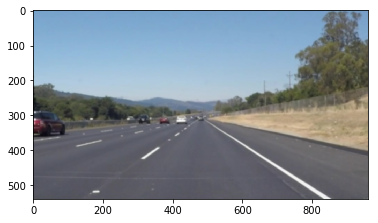

In [4]:
smooth_img = lf.smoothImage(img)
byplot.imshow(smooth_img)

#### Convert to gray image

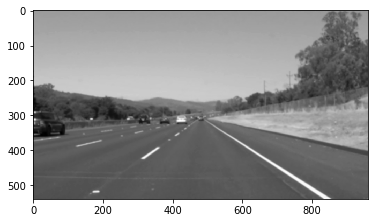

In [5]:
gray_img = lf.imageToGray(smooth_img)
byplot.imshow(gray_img,cmap='gray')

#### Mask Gray Image

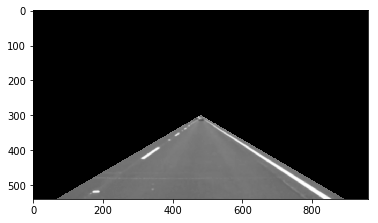

In [6]:
masked_img = lf.maskImage(gray_img)
byplot.imshow(masked_img,cmap='Greys_r')

#### Remove Gray Color below threshold

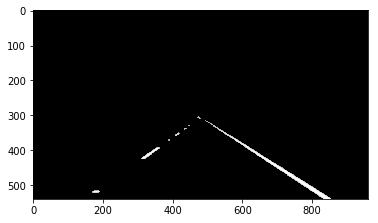

In [7]:
thres_img = lf.imageBelowThresToBlack(masked_img)
byplot.imshow(masked_img,cmap='Greys_r')

#### Apply canny edge detection

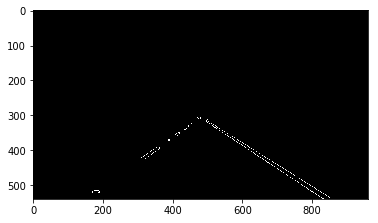

In [8]:
canny_edges=lf.cannyEdgeDetection(thres_img)
byplot.imshow(canny_edges,cmap='Greys_r')

#### Get hough lines

In [9]:
hough_lines = lf.houghLines(canny_edges)
print(hough_lines.shape[0], 'lines found with coordinates:\n\n[[x1 y1 x2 y2]]\n\n', hough_lines)

11 lines found with coordinates:

[[x1 y1 x2 y2]]

 [[[509 322 854 537]]

 [[473 304 636 410]]

 [[471 307 657 424]]

 [[693 449 830 538]]

 [[182 522 362 396]]

 [[472 304 832 538]]

 [[311 420 480 310]]

 [[309 423 419 354]]

 [[497 315 854 538]]

 [[189 521 439 339]]

 [[171 516 480 307]]]


#### Plot lane marking on original image

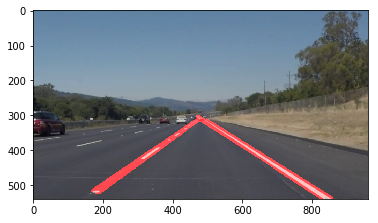

In [10]:
lf.houghLinesToImage(img, hough_lines)

# Try images

In [11]:
test_images = os.listdir('test_images')
print(test_images)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


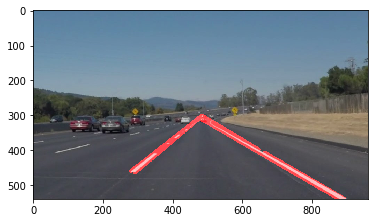

In [12]:
#for test_image in test_images:
lf.find('test_images/' + test_images[0])

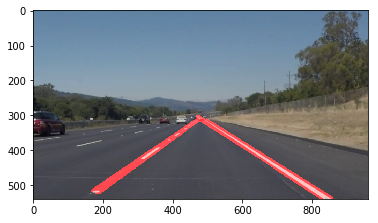

In [13]:
    lf.find('test_images/' + test_images[1])

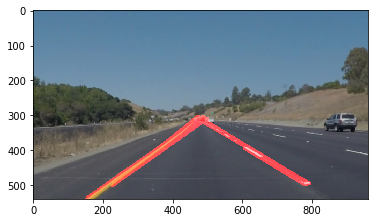

In [14]:
lf.find('test_images/' + test_images[2])

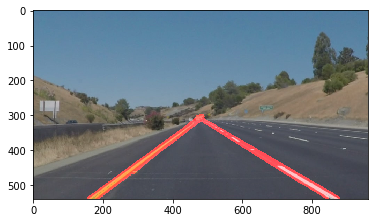

In [15]:
lf.find('test_images/' + test_images[3])

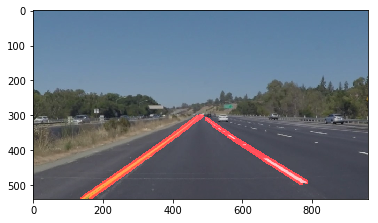

In [16]:
lf.find('test_images/' + test_images[4])

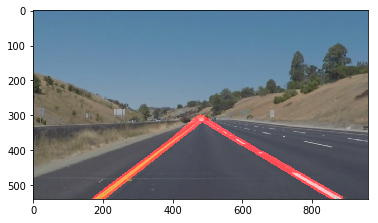

In [17]:
lf.find('test_images/' + test_images[5])

# Try videos

In [18]:
test_videos = os.listdir('test_videos')
print(test_videos)

['challenge.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4']


In [19]:
lf.find('test_videos/' + test_videos[1])

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 35.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.12 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/""" + test_videos[1] + """">
</video>
""")

In [21]:
lf.find('test_videos/' + test_videos[2])

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:20<00:00, 33.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 21.2 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/""" + test_videos[2] + """">
</video>
""")

# Try challange video
### As can be ssen espacially the light patch confuses the image processing functions

In [23]:
lf.find('test_videos/' + test_videos[0])

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 16.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 16.2 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/""" + test_videos[0] + """">
</video>
""")